# Diffusivity experiements

Diffusivity as a function of a tracer?

In [615]:
using Oceananigans, Oceananigans.Advection, Oceananigans.Fields, Oceananigans.Grids
using Oceananigans.AbstractOperations
using Oceananigans.OutputWriters
using JLD2
using Plots

In [616]:
grid2D = RegularCartesianGrid(topology = (Bounded, Bounded, Bounded),
                              size=(1, 64, 64), 
                              extent=(2π, 2π, 2π))

RegularCartesianGrid{Float64, Bounded, Bounded, Bounded}
                   domain: x ∈ [0.0, 6.283185307179586], y ∈ [8.410780489584512e-18, 6.283185307179587], z ∈ [-6.283185307179586, 5.517472001167444e-16]
                 topology: (Bounded, Bounded, Bounded)
  resolution (Nx, Ny, Nz): (1, 64, 64)
   halo size (Hx, Hy, Hz): (1, 1, 1)
grid spacing (Δx, Δy, Δz): (6.283185307179586, 0.09817477042468103, 0.09817477042468103)

In [617]:
v_bcs = VVelocityBoundaryConditions(grid2D,
           top = BoundaryCondition(Value, 0.0),
        bottom = BoundaryCondition(Value, 0.0),
         north = BoundaryCondition(NormalFlow, 0.0),
         south = BoundaryCondition(NormalFlow, 0.0)
)
w_bcs = WVelocityBoundaryConditions(grid2D,
        north = BoundaryCondition(Value, 0.0),
        south = BoundaryCondition(Value, 0.0),
          top = BoundaryCondition(NormalFlow, 0.0),
       bottom = BoundaryCondition(NormalFlow, 0.0)
)

Oceananigans.FieldBoundaryConditions (NamedTuple{(:x, :y, :z)}), with boundary conditions
├── x: CoordinateBoundaryConditions{BoundaryCondition{Flux,Nothing},BoundaryCondition{Flux,Nothing}}
├── y: CoordinateBoundaryConditions{BoundaryCondition{Value,Float64},BoundaryCondition{Value,Float64}}
└── z: CoordinateBoundaryConditions{BoundaryCondition{NormalFlow,Float64},BoundaryCondition{NormalFlow,Float64}}

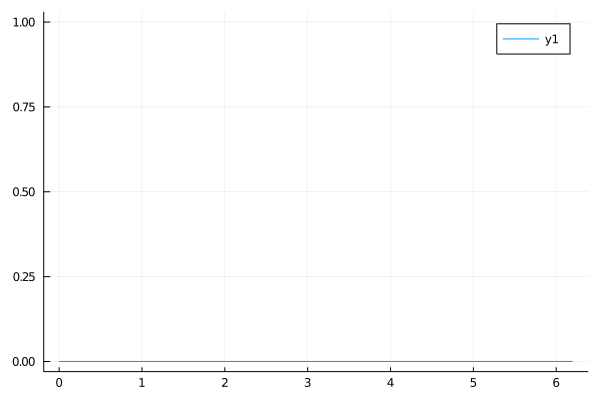

In [618]:
initial_κ(x, y, z, t) = 0*2e-3 * tanh(y-π) + 2e-4

plot(0:0.1:2π, initial_κ.(0, 0:0.1:2π, 0, 0))

In [619]:
model2D = IncompressibleModel(timestepper = :RungeKutta3,
                      advection = WENO5(),
                           grid = grid2D,
                       buoyancy = BuoyancyTracer(),
                        tracers = :b,
            boundary_conditions = (v=v_bcs, w=w_bcs),
                        closure = IsotropicDiffusivity(ν = 2e-4, 
                                                       #κ = (x, y, z, t) -> initial_κ(x, y, z, t))
                                                       κ = 2e-4)
)

IncompressibleModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: RegularCartesianGrid{Float64, Bounded, Bounded, Bounded}(Nx=1, Ny=64, Nz=64)
├── tracers: (:b,)
├── closure: IsotropicDiffusivity{Float64,NamedTuple{(:b,),Tuple{Float64}}}
├── buoyancy: BuoyancyTracer
└── coriolis: Nothing

### Setting buoyancy

In [620]:
height = 1.0;
width = 0.5;

#initial_buoyancy(x,y,z) = 0.1 * (1.0-tanh(abs(x-π)/width)) * (1.0 - tanh(abs(z+2*π)/height));
#initial_buoyancy(x,y,z) = 0.1 * (1.0-tanh(abs(x-π)/width)) * -(1.0 - tanh(abs(z+0*π)/height));
initial_buoyancy(x,y,z) = 1e-4*(width>sqrt((y-π)^2 + (z+2π-height)^2))

set!(model2D, b=initial_buoyancy)

In [621]:
u, v, w = model2D.velocities;
b = model2D.tracers.b

Field located at (Cell, Cell, Cell)
├── data: OffsetArrays.OffsetArray{Float64,3,Array{Float64,3}}, size: (7, 70, 70)
├── grid: RegularCartesianGrid{Float64, Bounded, Bounded, Bounded}(Nx=1, Ny=64, Nz=64)
└── boundary conditions: x=(west=ZeroFlux, east=ZeroFlux), y=(south=ZeroFlux, north=ZeroFlux), z=(bottom=ZeroFlux, top=ZeroFlux)

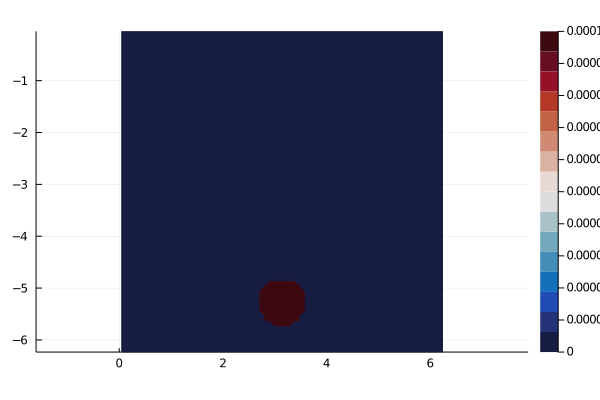

In [622]:
s = sqrt(v^2 + w^2)

s_field = ComputedField(s)

ω = ∂y(w) - ∂z(v)

ω_field = ComputedField(ω)

xb, yb, zb = nodes(b)
contourf(yb,zb,b[1,1:64,1:64]',color=:balance, aspect_ratio=:equal)

In [623]:
progress(sim) = @info "Iteration: $(sim.model.clock.iteration), time: $(round(Int, sim.model.clock.time))"

simulation = Simulation(model2D, Δt=0.2, 
    stop_time=400.0, iteration_interval=200, progress=progress);

using Oceananigans.OutputWriters

simulation.output_writers[:fields] = 
        JLD2OutputWriter(model2D, 
                         (b=b,v=v,w=w,ω=ω_field, s=s_field),
                          schedule = TimeInterval(1.0),
                          prefix = "gravity_current",
                          force = true);

In [624]:
run!(simulation)

┌ Info: Iteration: 200, time: 40
└ @ Main In[623]:1
┌ Info: Iteration: 400, time: 80
└ @ Main In[623]:1
┌ Info: Iteration: 600, time: 120
└ @ Main In[623]:1
┌ Info: Iteration: 800, time: 160
└ @ Main In[623]:1
┌ Info: Iteration: 1000, time: 200
└ @ Main In[623]:1
┌ Info: Iteration: 1200, time: 240
└ @ Main In[623]:1
┌ Info: Iteration: 1400, time: 280
└ @ Main In[623]:1
┌ Info: Iteration: 1600, time: 320
└ @ Main In[623]:1
┌ Info: Iteration: 1800, time: 360
└ @ Main In[623]:1
┌ Info: Iteration: 2000, time: 400
└ @ Main In[623]:1
┌ Info: Iteration: 2200, time: 440
└ @ Main In[623]:1
┌ Info: Simulation is stopping. Model time 7.333 minutes has hit or exceeded simulation stop time 6.667 minutes.
└ @ Oceananigans.Simulations /Users/williamdavis/.julia/packages/Oceananigans/IbUoB/src/Simulations/run.jl:40


┌ Info: Saved animation to 
│   fn = /Users/williamdavis/Dropbox/viscosometry/code/tmp.gif
└ @ Plots /Users/williamdavis/.julia/packages/Plots/w4QRq/src/animation.jl:104


Plots.AnimatedGif("/Users/williamdavis/Dropbox/viscosometry/code/tmp.gif")
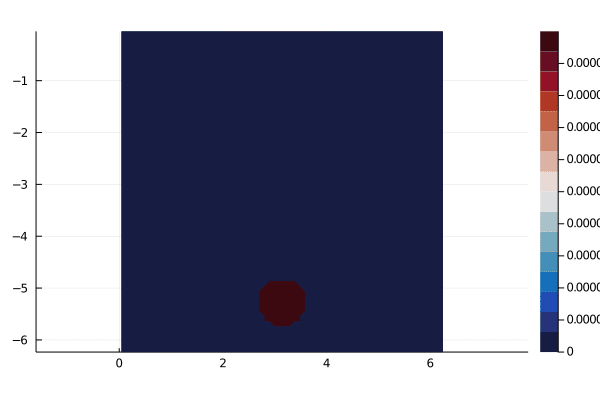

In [625]:
file = jldopen(simulation.output_writers[:fields].filepath)
iterations = parse.(Int, keys(file["timeseries/t"]));
# Plot buoyancy

@gif for iter in iterations
    # retrieve solution from JLD2 file

    #t = file["timeseries/t/$iter"]
    b_snapshot = file["timeseries/b/$iter"][1, :, :]
    #b_snapshot = file["timeseries/v/$iter"][1, 1:64, 1:64]
    #b_snapshot = file["timeseries/w/$iter"][1, 1:64, 1:64]
    #b_snapshot = file["timeseries/ω/$iter"][1, 1:64, 1:64]
    #b_snapshot = file["timeseries/s/$iter"][1, 1:64, 1:64]

    contourf(yb, zb, b_snapshot',color=:balance, 
             #clim=(0.0,0.001),
             aspect_ratio=:equal) 
end every 10